<img src="imgs/GeorgiaTech_RGB.png" alt="GeorgiaTech_RGB" width="200"/>

# <span style='color:#B3A369'> <b>Analyze Participant Data & Create Epochs</b> </span>

> <b> Notebook Author:</b> Brian Keith (bkeith9@gatech.edu) <br>
> <b> Purpose:</b> Perform initial analysis of the data and create the split datasets based on variations in segment length and overlap. <br>
> 
> **Data Citation:**
> - Andreas Miltiadous and Katerina D. Tzimourta and Theodora Afrantou and Panagiotis Ioannidis and Nikolaos Grigoriadis and Dimitrios G. Tsalikakis and Pantelis Angelidis and Markos G. Tsipouras and Evripidis Glavas and Nikolaos Giannakeas and Alexandros T. Tzallas (2023). A dataset of EEG recordings from: Alzheimer's disease, Frontotemporal dementia and Healthy subjects. OpenNeuro. [Dataset] doi: doi:10.18112/openneuro.ds004504.v1.0.6
>
> **Data Source:**
> - Dataset download as a zip file from: https://nemar.org/dataexplorer/detail?dataset_id=ds004504
>
> **Data Information:**
> - Cognitive and neuropsychological state was evaluated by the international Mini-Mental State Examination (**MMSE**)
>   - The MMSE score ranges from 0 to 30, with *a lower MMSE indicating more severe cognitive decline*.
> - Recordings include the EEG signal from 19 scalp electrodes `Fp1`, `Fp2`, `F7`, `F3`, `Fz`, `F4`, `F8`, `T3`, `C3`, `Cz`, `C4`, `T4`, `T5`, `P3`, `Pz`, `P4`, `T6`, `O1`, & `O2`, and 2 reference electrodes, placed according to the 10–20 international system (`A1` & `A2`).
>   - Sampling Rate = 500 Hz
>   - Resolution = 10 uV/mm
>   - Each recording lasted approximately 13.5 min for the AD group (min = 5.1, max = 21.3), 12 min for the FTD group (min = 7.9, max = 16.9), and 13.8 min for the CN group (min = 12.5, max = 16.5). 
>       - In total, 485.5 min of AD, 276.5 min of FTD, and 402 min of CN recordings were collected and are included in the dataset.
> - 88 participants total
>   - Alzheimer’s disease (**AD**) patients (n=36)
>       - `Group = A`
>   - Frontotemporal dementia (**FTD**) patients (n=23)
>       - `Group = F`
>   - Healthy controls (**CN**) participants (n=29)
>       - `Group = C`
>
> 


# <span style='color:#B3A369'> Initial Tasks </span>

## <span style='color:#003057'> Set Params & Load Necessary Libraries </span>

In [1]:
SEED_VAL = 903027850 #GTID
SENSORS = [
    'Fp1', 'Fp2', 
    'F3', 'F4', 
    'C3', 'C4', 
    'P3', 'P4', 
    'O1', 'O2', 
    'F7', 'F8', 
    'T3', 'T4', 
    'T5', 'T6', 
    'Fz', 'Cz', 
    'Pz',
]
PALETTE = [
    '#003057',
    '#66829a',
    '#857437',
    '#BFB37C',
    '#54585A',
    '#a9abac',
]


import pathlib
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from math import ceil
from timeit import default_timer

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', 200)
plt.rcParams["font.family"] = "Georgia"

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)

#custom utils module from helpers/utils.py
from helpers.utils import printmd, export_code,format_timing
from helpers.calcs import create_epochs

## <span style='color:#003057'>Read in Data</span>

In [2]:
data_file = 'data/ConsolidatedParticipantData.pkl'

with open(data_file, 'rb') as f:
    data_dict = pickle.load(f)

participants = data_dict['participants']
labels = data_dict['labels']
data_raw = data_dict['data_raw']
data_pre = data_dict['data_pre']

printmd('# <b><u>Data Summary</u></b>')
printmd(f'## <u>Participant Data Sample Preview:</u>')
print('Number of participants:', len(participants))
for i in participants.Group.unique():
    print(f'# of participants in Group {i}:', len(participants[participants.Group == i]))
display(participants.sample(5, random_state=SEED_VAL))
participants.info()

printmd(f'## <u>Label Data Sample Preview:</u>')
display(labels.sample(5, random_state=SEED_VAL))
labels.info()

printmd(f'## <u>EEG Data (Raw) Sample Preview:</u>')
display(data_raw.sample(5, random_state=SEED_VAL))
data_raw.info()

printmd(f'## <u>EEG Data (Preprocessed) Sample Preview:</u>')
display(data_pre.sample(5, random_state=SEED_VAL))
data_pre.info()


# <span style="color:#B3A369"> <b><u>Data Summary</u></b></span>

## <span style="color:#003057"> <u>Participant Data Sample Preview:</u></span>

Number of participants: 88
# of participants in Group A: 36
# of participants in Group C: 29
# of participants in Group F: 23


,participant_id,Gender,Age,Group,MMSE
20,sub-021,M,79,A,22
47,sub-048,M,65,C,30
23,sub-024,F,69,A,20
38,sub-039,M,70,C,30
50,sub-051,F,75,C,30


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88 entries, 0 to 87
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   participant_id  88 non-null     object
 1   Gender          88 non-null     object
 2   Age             88 non-null     int64 
 3   Group           88 non-null     object
 4   MMSE            88 non-null     int64 
dtypes: int64(2), object(3)
memory usage: 3.6+ KB


## <span style="color:#003057"> <u>Label Data Sample Preview:</u></span>

,participant_id,labels,type,theta,radius,X,Y,Z,sph_theta,sph_phi,sph_radius,urchan,ref
297,sub-016,T3,EEG,-100.776424,0.534588,-16.0187,84.1611,-9.346,100.776424,-6.225806,86.18026,13,A1 A2
1240,sub-066,C4,EEG,99.224598,0.260682,-10.9003,-67.1179,63.58,-99.224598,43.077206,93.091597,6,A1 A2
18,sub-001,Pz,EEG,179.770649,0.247085,-81.115,-0.3247,82.615,-179.770649,45.524667,115.779907,19,A1 A2
178,sub-010,P4,EEG,144.679127,0.330934,-78.5602,-55.6667,56.561,-144.679127,30.431813,111.667512,8,A1 A2
725,sub-039,F4,EEG,43.66767,0.341495,54.3048,-51.8362,40.814,-43.66767,28.530945,85.450486,4,A1 A2


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1672 entries, 0 to 1671
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   participant_id  1672 non-null   object
 1   labels          1672 non-null   object
 2   type            1672 non-null   object
 3   theta           1672 non-null   object
 4   radius          1672 non-null   object
 5   X               1672 non-null   object
 6   Y               1672 non-null   object
 7   Z               1672 non-null   object
 8   sph_theta       1672 non-null   object
 9   sph_phi         1672 non-null   object
 10  sph_radius      1672 non-null   object
 11  urchan          1672 non-null   object
 12  ref             1672 non-null   object
dtypes: object(13)
memory usage: 169.9+ KB


## <span style="color:#003057"> <u>EEG Data (Raw) Sample Preview:</u></span>

,participant_id,time_s,time_ms,Fp1,Fp2,F3,F4,C3,C4,P3,P4,O1,O2,F7,F8,T3,T4,T5,T6,Fz,Cz,Pz
22775778,sub-055,786.556,786556,-11.621094,-97.363274,-112.988274,-228.222626,-48.339844,-73.339836,0.000000,-164.746094,15.917969,-22.363281,-111.425774,-195.507812,-55.371094,-23.242188,-61.523430,-78.613274,-28.808594,-74.609367,-45.019531
25588165,sub-062,794.030,794030,216.748047,169.482422,-47.705078,-48.095703,-35.986328,103.759758,-40.478516,-56.201172,102.880852,-513.623047,153.369141,92.431633,3.369139,256.005859,26.318357,328.173828,135.595703,204.541016,62.744133
30683973,sub-076,726.146,726146,-73.388664,-53.466793,-46.728512,-103.369141,-5.126953,-42.138668,-34.716793,-282.861298,180.322266,-150.537094,-60.595699,54.248043,-7.373046,-91.650391,-76.416016,-91.455078,-39.892574,-106.689453,-45.458981
33301461,sub-083,199.822,199822,-170.458984,86.279297,-71.923820,-376.806610,-51.611320,106.591797,-65.478508,-410.595673,-260.009735,-125.146477,190.966797,-57.958977,-85.498039,81.201172,-226.220673,145.166016,122.216789,-197.021454,-156.396484
15416400,sub-038,652.400,652400,-21.728516,-27.392578,-18.115234,-1.416016,-23.583984,44.580074,-18.603516,-39.697266,-40.771484,-57.763672,-32.666016,-44.482422,-38.916016,-21.630859,-39.501953,-95.361328,25.244139,6.005858,-3.564454


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35295150 entries, 0 to 35295149
Data columns (total 22 columns):
 #   Column          Dtype   
---  ------          -----   
 0   participant_id  category
 1   time_s          float64 
 2   time_ms         int32   
 3   Fp1             float32 
 4   Fp2             float32 
 5   F3              float32 
 6   F4              float32 
 7   C3              float32 
 8   C4              float32 
 9   P3              float32 
 10  P4              float32 
 11  O1              float32 
 12  O2              float32 
 13  F7              float32 
 14  F8              float32 
 15  T3              float32 
 16  T4              float32 
 17  T5              float32 
 18  T6              float32 
 19  Fz              float32 
 20  Cz              float32 
 21  Pz              float32 
dtypes: category(1), float32(19), float64(1), int32(1)
memory usage: 2.9 GB


## <span style="color:#003057"> <u>EEG Data (Preprocessed) Sample Preview:</u></span>

,participant_id,time_s,time_ms,Fp1,Fp2,F3,F4,C3,C4,P3,P4,O1,O2,F7,F8,T3,T4,T5,T6,Fz,Cz,Pz
32542217,sub-082,122.534000,122534,55.612003,49.114220,56.502449,48.009296,60.660671,48.593147,60.911224,56.049191,55.102280,60.634426,57.135029,47.040554,58.565170,48.496525,59.686626,54.447216,51.309628,58.016029,63.313313
2808924,sub-009,216.428001,216428,1.240283,-6.643512,0.464752,-2.324826,-0.101641,-2.755804,-4.013057,-4.187889,-5.137672,-8.142000,0.833606,0.045650,0.974664,-3.741974,-1.338448,-1.895064,1.456802,-1.160033,-5.866726
34147642,sub-086,430.424174,430424,51.319309,-7.081347,39.043911,104.583664,10.173483,9.507556,10.847269,7.227322,13.537377,-0.704005,41.960365,76.553040,26.318298,36.205383,65.052589,47.897881,7.874752,1.582152,-18.402962
15664058,sub-039,526.636010,526636,53.326717,57.241638,48.454697,58.195446,48.431637,48.214825,37.631847,30.776978,37.224407,30.358116,49.023556,53.303719,53.174297,54.247028,50.075249,38.249268,65.244789,46.609028,19.475323
32428114,sub-081,718.808011,718808,-6.014253,-3.025269,-3.396809,-5.539411,-0.215203,-4.289495,0.709703,-2.151258,0.142568,0.841937,-11.131310,-2.526326,-3.805894,-5.008454,-0.293050,-4.965789,-5.638639,-0.278249,0.136206


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34915560 entries, 0 to 34915559
Data columns (total 22 columns):
 #   Column          Dtype   
---  ------          -----   
 0   participant_id  category
 1   time_s          float64 
 2   time_ms         int32   
 3   Fp1             float32 
 4   Fp2             float32 
 5   F3              float32 
 6   F4              float32 
 7   C3              float32 
 8   C4              float32 
 9   P3              float32 
 10  P4              float32 
 11  O1              float32 
 12  O2              float32 
 13  F7              float32 
 14  F8              float32 
 15  T3              float32 
 16  T4              float32 
 17  T5              float32 
 18  T6              float32 
 19  Fz              float32 
 20  Cz              float32 
 21  Pz              float32 
dtypes: category(1), float32(19), float64(1), int32(1)
memory usage: 2.9 GB


# <span style='color:#B3A369'> Data Investigation </span>

## <span style='color:#003057'> Check Participant Group EEG Times </span>

Mostly just to validate that the time provided by the researchers is in ms based on the 500 hz rate.

> "Each recording lasted approximately 13.5 min for the AD group (min = 5.1, max = 21.3), 12 min for the FTD group (min = 7.9, max = 16.9), and 13.8 min for the CN group (min = 12.5, max = 16.5). In total, 485.5 min of AD, 276.5 min of FTD, and 402 min of CN recordings were collected and are included in the dataset."

Based on the results, it appears the timings from the researchers are based on the preprocessed data.

In [3]:
grp_times_raw = participants.merge(
    data_raw.groupby('participant_id')['time_s'].max(), left_on='participant_id', right_index=True
    ).groupby('Group')['time_s'].agg(['min', 'max', 'mean', 'sum'])

grp_times_raw.columns = ['MinTime', 'MaxTime', 'MeanTime', 'TotalTime']
grp_times_raw.index.name = None
grp_times_raw = grp_times_raw/60

printmd('### <u>EEG Data (Raw) Time Summary (in minutes):</u>')
display(grp_times_raw)

grp_times_pre = participants.merge(
    data_pre.groupby('participant_id')['time_s'].max(), left_on='participant_id', right_index=True
    ).groupby('Group')['time_s'].agg(['min', 'max', 'mean', 'sum'])

grp_times_pre.columns = ['MinTime', 'MaxTime', 'MeanTime', 'TotalTime']
grp_times_pre.index.name = None
grp_times_pre = grp_times_pre/60

printmd('### <u>EEG Data (Preprocessed) Time Summary (in minutes):</u>')
display(grp_times_pre)

### <span style="color:#54585A"> <u>EEG Data (Raw) Time Summary (in minutes):</u></span>

,MinTime,MaxTime,MeanTime,TotalTime
A,5.118300,21.518300,13.612606,490.053800
C,12.524967,16.951633,14.042266,407.225700
F,7.984967,17.114967,12.140112,279.222567


### <span style="color:#54585A"> <u>EEG Data (Preprocessed) Time Summary (in minutes):</u></span>

,MinTime,MaxTime,MeanTime,TotalTime
A,5.101633,21.361967,13.487458,485.548477
C,12.474633,16.497967,13.855737,401.816379
F,7.984967,16.908300,12.021054,276.484241


## <span style='color:#003057'> Visualize difference in the Raw and Preproccesed Data </span>

Compare raw vs. preprocessed data similar to Figure 2 in the paper. Just done to get my own look at the data. Not sure at this time if I will use the raw data or the preprocessed data for modeling. For now, I will use the preprocessed data.

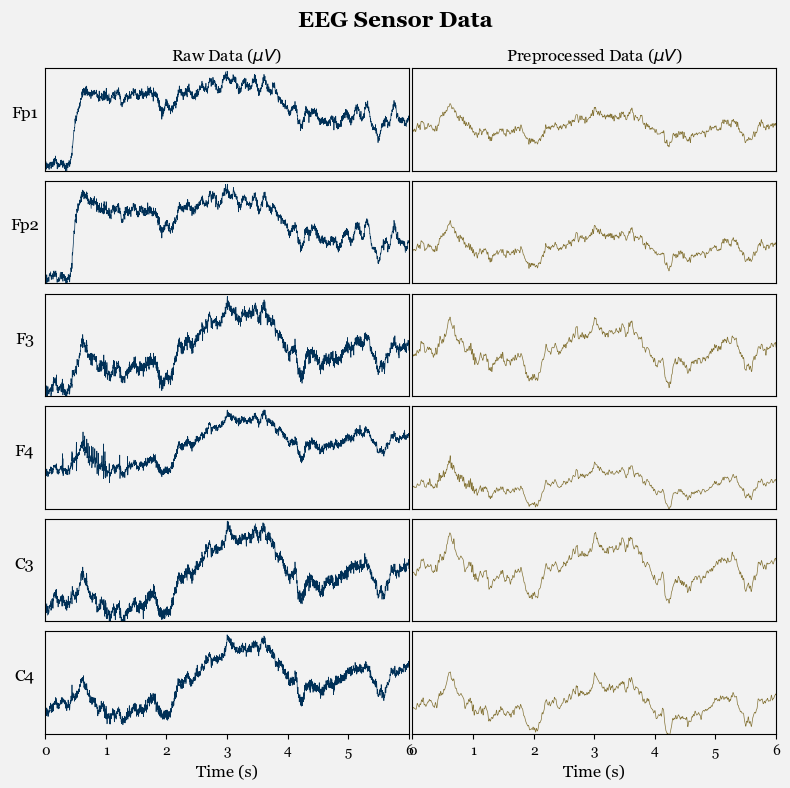

In [4]:
obj_partic = 'sub-001'
filt_secs = 6

vis_raw = data_raw.query('participant_id == @obj_partic & time_s <= @filt_secs')
vis_pre = data_pre.query('participant_id == @obj_partic & time_s <= @filt_secs')

test_sensors = SENSORS[:6]

fig, ax = plt.subplots(len(test_sensors), 2, figsize=(8,8))

for i, sensor in enumerate(test_sensors):
    ax[i,0].plot(vis_raw.time_s, vis_raw[sensor], color = PALETTE[0], linewidth = 0.5, label = 'Raw')
    ax[i,1].plot(vis_pre.time_s, vis_pre[sensor], color = PALETTE[2], linewidth = 0.5, label = 'Preprocessed')
    
    ax[i,0].set_ylabel(sensor, fontsize=12, rotation=0, labelpad=15)
    max_y, min_y = max(vis_raw[sensor].max(), vis_pre[sensor].max()), min(vis_raw[sensor].min(), vis_pre[sensor].min())
    
    for j in range(0, len(ax[i])):
        ax[i,j].set_yticks([])
        ax[i,j].set_ylim(min_y-min_y*0.05, max_y + max_y*0.05)
        ax[i,j].set_xlim(0, filt_secs)
        ax[i,j].patch.set_facecolor('#F2F2F2')

        
        if i != len(test_sensors) - 1:
            ax[i,j].set_xticks([])
        else:
            ax[i,j].set_xlabel('Time (s)', fontsize=12)
            ax[i,j].set_xlabel('Time (s)', fontsize=12)
        
    if i == 0:
        ax[i,0].set_title('Raw Data ($\mu V$)', fontsize=12)
        ax[i,1].set_title('Preprocessed Data ($\mu V$)', fontsize=12)
    
fig.patch.set_facecolor('#F2F2F2')
plt.suptitle('EEG Sensor Data', fontsize=16, fontweight='bold',)
plt.tight_layout()
plt.subplots_adjust(hspace=0.1, wspace=0.01)
fig.savefig(f'figs/Raw_v_Preprocessed.png', dpi=300, bbox_inches='tight')
plt.show()

# <span style='color:#B3A369'> PSD & RBP Transformations </span>

This code uses the same parameters as the paper. With a segment duration of 4 seconds and a 50% overlap, this means that there is a rolling window of 2 seconds for the PSD and RBP calculations. The code that calculates the PSD and RBP uses the `welch` function from `scipy.signal`. See `helpers/calcs.py` for the detailed implementation. 

## <span style='color:#003057'> Example Signal Decomposition</span>

## <span style="color:#003057"> <u>Example of EEG Data Segmentation:</u></span>

Data for sub-001 processed. | Total Segments: 300 | Time: 0:00:02.529512 | Elapsed: 0:00:02.663087
Data for sub-002 processed. | Total Segments: 397 | Time: 0:00:03.326594 | Elapsed: 0:00:06.028262


### <span style="color:#54585A"> <u>Epoch Data Sample Preview:</u></span>

Number of participants: 2
Total of segments: 697 | Avg. Segments per Participant: 348.50
Total Processing Time: 0:00:06.078555


,participant_id,seg_start,seg_end,Fp1_delta_psd,Fp1_delta_rbp,Fp1_theta_psd,Fp1_theta_rbp,Fp1_alpha_psd,Fp1_alpha_rbp,Fp1_beta_psd,Fp1_beta_rbp,Fp1_gamma_psd,Fp1_gamma_rbp,Fp2_delta_psd,Fp2_delta_rbp,Fp2_theta_psd,Fp2_theta_rbp,Fp2_alpha_psd,Fp2_alpha_rbp,Fp2_beta_psd,Fp2_beta_rbp,Fp2_gamma_psd,Fp2_gamma_rbp,F3_delta_psd,F3_delta_rbp,F3_theta_psd,F3_theta_rbp,F3_alpha_psd,F3_alpha_rbp,F3_beta_psd,F3_beta_rbp,F3_gamma_psd,F3_gamma_rbp,F4_delta_psd,F4_delta_rbp,F4_theta_psd,F4_theta_rbp,F4_alpha_psd,F4_alpha_rbp,F4_beta_psd,F4_beta_rbp,F4_gamma_psd,F4_gamma_rbp,C3_delta_psd,C3_delta_rbp,C3_theta_psd,C3_theta_rbp,C3_alpha_psd,C3_alpha_rbp,C3_beta_psd,C3_beta_rbp,C3_gamma_psd,C3_gamma_rbp,C4_delta_psd,C4_delta_rbp,C4_theta_psd,C4_theta_rbp,C4_alpha_psd,C4_alpha_rbp,C4_beta_psd,C4_beta_rbp,C4_gamma_psd,C4_gamma_rbp,P3_delta_psd,P3_delta_rbp,P3_theta_psd,P3_theta_rbp,P3_alpha_psd,P3_alpha_rbp,P3_beta_psd,P3_beta_rbp,P3_gamma_psd,P3_gamma_rbp,P4_delta_psd,P4_delta_rbp,P4_theta_psd,P4_theta_rbp,P4_alpha_psd,P4_alpha_rbp,P4_beta_psd,P4_beta_rbp,P4_gamma_psd,P4_gamma_rbp,O1_delta_psd,O1_delta_rbp,O1_theta_psd,O1_theta_rbp,O1_alpha_psd,O1_alpha_rbp,O1_beta_psd,O1_beta_rbp,O1_gamma_psd,O1_gamma_rbp,O2_delta_psd,O2_delta_rbp,O2_theta_psd,O2_theta_rbp,O2_alpha_psd,O2_alpha_rbp,O2_beta_psd,O2_beta_rbp,O2_gamma_psd,O2_gamma_rbp,F7_delta_psd,F7_delta_rbp,F7_theta_psd,F7_theta_rbp,F7_alpha_psd,F7_alpha_rbp,F7_beta_psd,F7_beta_rbp,F7_gamma_psd,F7_gamma_rbp,F8_delta_psd,F8_delta_rbp,F8_theta_psd,F8_theta_rbp,F8_alpha_psd,F8_alpha_rbp,F8_beta_psd,F8_beta_rbp,F8_gamma_psd,F8_gamma_rbp,T3_delta_psd,T3_delta_rbp,T3_theta_psd,T3_theta_rbp,T3_alpha_psd,T3_alpha_rbp,T3_beta_psd,T3_beta_rbp,T3_gamma_psd,T3_gamma_rbp,T4_delta_psd,T4_delta_rbp,T4_theta_psd,T4_theta_rbp,T4_alpha_psd,T4_alpha_rbp,T4_beta_psd,T4_beta_rbp,T4_gamma_psd,T4_gamma_rbp,T5_delta_psd,T5_delta_rbp,T5_theta_psd,T5_theta_rbp,T5_alpha_psd,T5_alpha_rbp,T5_beta_psd,T5_beta_rbp,T5_gamma_psd,T5_gamma_rbp,T6_delta_psd,T6_delta_rbp,T6_theta_psd,T6_theta_rbp,T6_alpha_psd,T6_alpha_rbp,T6_beta_psd,T6_beta_rbp,T6_gamma_psd,T6_gamma_rbp,Fz_delta_psd,Fz_delta_rbp,Fz_theta_psd,Fz_theta_rbp,Fz_alpha_psd,Fz_alpha_rbp,Fz_beta_psd,Fz_beta_rbp,Fz_gamma_psd,Fz_gamma_rbp,Cz_delta_psd,Cz_delta_rbp,Cz_theta_psd,Cz_theta_rbp,Cz_alpha_psd,Cz_alpha_rbp,Cz_beta_psd,Cz_beta_rbp,Cz_gamma_psd,Cz_gamma_rbp,Pz_delta_psd,Pz_delta_rbp,Pz_theta_psd,Pz_theta_rbp,Pz_alpha_psd,Pz_alpha_rbp,Pz_beta_psd,Pz_beta_rbp,Pz_gamma_psd,Pz_gamma_rbp
0,sub-001,0,4000,122.883514,0.760544,15.706409,0.097209,4.986570,0.030863,7.082795,0.043836,10.913929,0.067548,118.405029,0.768351,17.356348,0.112628,4.432917,0.028766,5.584762,0.036241,8.323713,0.054014,104.130196,0.776080,17.199083,0.128184,3.872688,0.028863,4.085264,0.030447,4.887379,0.036426,107.459274,0.757577,18.101254,0.127612,4.001835,0.028213,4.657236,0.032833,7.626449,0.053766,106.028145,0.802213,15.121582,0.114410,3.989193,0.030182,3.928622,0.029724,3.102090,0.023471,106.377419,0.813422,13.977216,0.106878,3.341740,0.025553,3.995417,0.030551,3.085915,0.023597,108.215698,0.808558,15.564062,0.116290,4.148880,0.030999,3.500827,0.026157,2.408339,0.017994,114.429771,0.818246,14.359684,0.102681,3.961608,0.028328,4.367887,0.031233,2.728717,0.019512,111.706802,0.784206,17.227486,0.120941,5.329700,0.037416,4.490146,0.031522,3.691571,0.025916,115.342407,0.792296,17.165619,0.117912,4.926466,0.033840,4.822796,0.033128,3.322755,0.022824,108.945587,0.788309,15.948678,0.115401,4.283027,0.030991,4.604884,0.033320,4.419545,0.031979,110.646469,0.754847,18.198099,0.124150,3.969653,0.027082,5.549412,0.037859,8.217645,0.056062,105.186340,0.778370,15.922930,0.117828,4.838093,0.035801,4.557729,0.033727,4.631619,0.034274,111.782639,0.782075,14.804406,0.103577,3.490140,0.024418,5.015215,0.035088,7.838543,0.054841,116.585846,0.778919,17.956888,0.119971,5.930702,0.039623,4.979208,0.033266,4.223756,0.028219,115.824448,0.805465,14.720361,0.102368,4.836006,0.033631,4.983404,0.034656,3.433986,0.023881,110.3951

## <span style="color:#003057"> <u>Example Visualization of Signal Decomposition:</u></span>

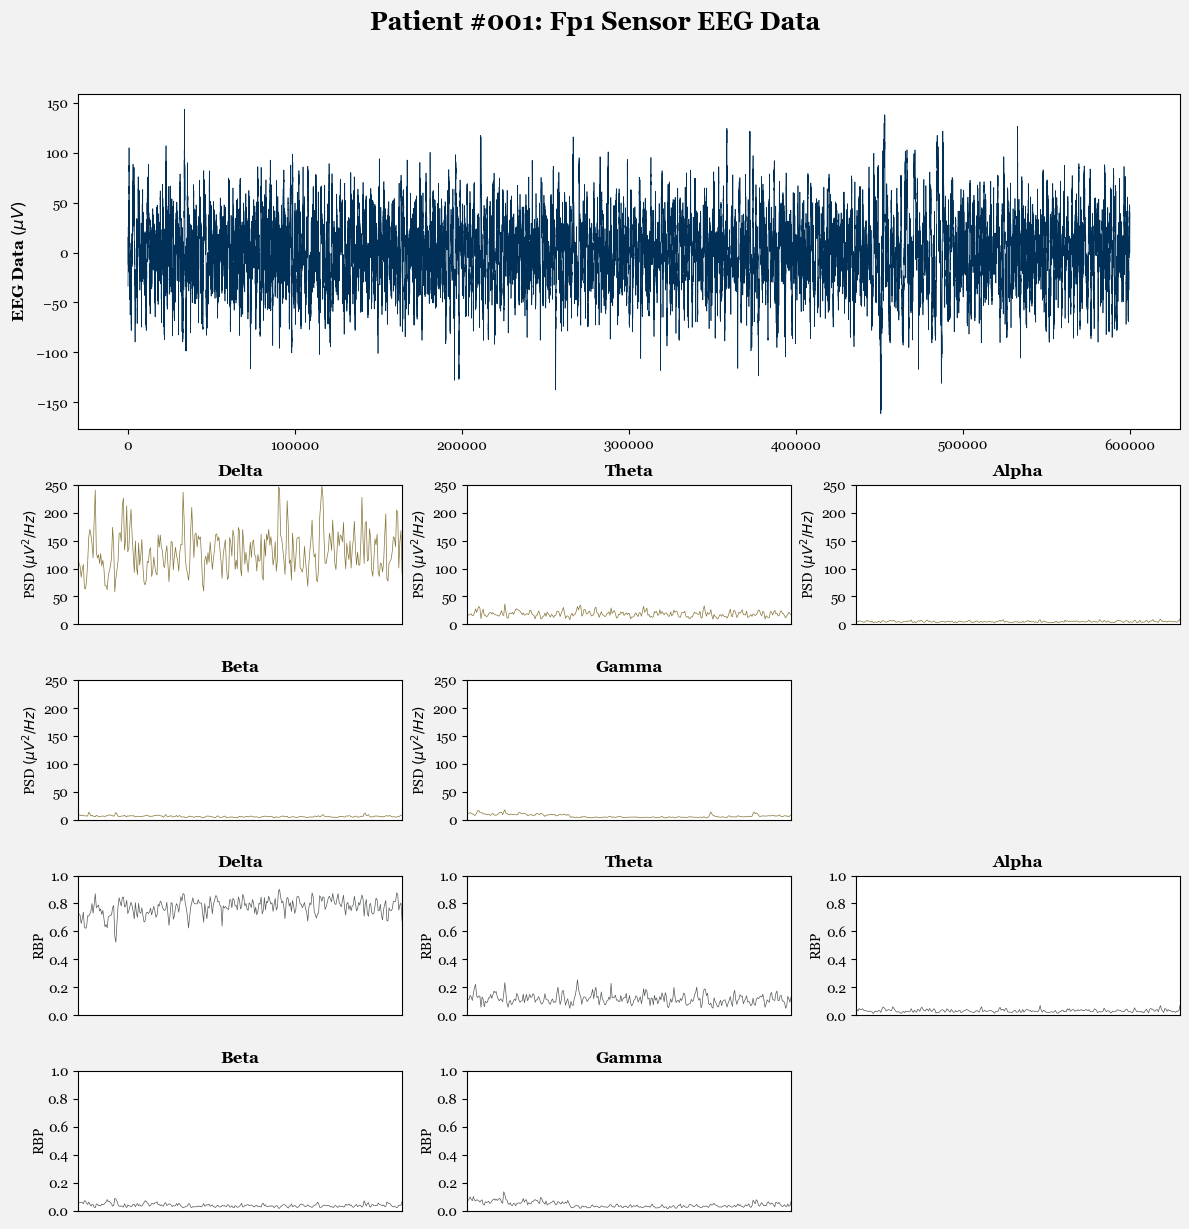

In [5]:
seg_dur = 4000  #4 seconds in ms
overlap = 0.5  #50% overlap

printmd('## <u>Example of EEG Data Segmentation:</u>')
epoch_data_example = create_epochs(
    data_pre,
    SENSORS,
    seg_dur,
    overlap,
    debug = True,
    verbose=True
)


printmd('## <u>Example Visualization of Signal Decomposition:</u>')
OBJ_SENSOR = 'Fp1'
#! prep data
comp_pre = data_pre.query('participant_id == @obj_partic')
comp_pre = comp_pre[['participant_id', 'time_s', 'time_ms', OBJ_SENSOR, ]]

comp_rbp = epoch_data_example.query('participant_id == @obj_partic')
const_cols = ['participant_id', 'seg_start', 'seg_end']
keep_rbp = [i for i in comp_rbp.columns if i.startswith(OBJ_SENSOR) and i.endswith('rbp')]
comp_rbp = comp_rbp[const_cols + keep_rbp]

comp_psd = epoch_data_example.query('participant_id == @obj_partic')
keep_psd = [i for i in comp_psd.columns if i.startswith(OBJ_SENSOR) and i.endswith('psd')]
comp_psd = comp_psd[const_cols + keep_psd]
max_y_psd = ceil(comp_psd[keep_psd].max().max()/10)*10

#! functions to make creating all the subplots less repetivive
def subplot_specs(pos: tuple, rowspan: int = 1, colspan: int = 1):
    return plt.subplot2grid((6, 3), pos, rowspan=rowspan, colspan=colspan)

def plot_data(ax, data, column_name, title, ylabel, ylim=1, pal_index = 2):
    ax.plot(data.seg_start, data[column_name], color=PALETTE[pal_index], linewidth=0.5)
    ax.set_title(title, fontsize=12, fontweight='bold')
    ax.set_ylabel(ylabel, labelpad=1)
    if ylim:
        ax.set_ylim(0, ylim)
    ax.set_xlim(0, max(data.seg_start))
    ax.set_xticks([])

fig = plt.figure(figsize=(12, 12))

ax_specs = {
    'eeg': subplot_specs((0, 0), rowspan=2, colspan=3),
    'delta_psd': subplot_specs((2, 0)),
    'theta_psd': subplot_specs((2, 1)),
    'alpha_psd': subplot_specs((2, 2)),
    'beta_psd': subplot_specs((3, 0)),
    'gamma_psd': subplot_specs((3, 1)),
    'delta_rbp': subplot_specs((4, 0)),
    'theta_rbp': subplot_specs((4, 1)),
    'alpha_rbp': subplot_specs((4, 2)),
    'beta_rbp': subplot_specs((5, 0)),
    'gamma_rbp': subplot_specs((5, 1))
}

ax_specs['eeg'].plot(comp_pre.time_ms, comp_pre.Fp1, color=PALETTE[0], linewidth=0.5)
ax_specs['eeg'].set_ylabel('EEG Data $(\mu V)$', fontsize=12, labelpad=5, fontweight='bold', rotation=90)

for band in list(dict.fromkeys(i.split('_')[0] for i in ax_specs.keys() if i != 'eeg')):
    plot_data(ax_specs[f'{band}_psd'], comp_psd, f'Fp1_{band}_psd', band.capitalize(), 'PSD $(\mu V^2/Hz)$', max_y_psd)
    plot_data(ax_specs[f'{band}_rbp'], comp_rbp, f'Fp1_{band}_rbp', band.capitalize(), 'RBP', pal_index = 4)

fig.patch.set_facecolor('#F2F2F2')
plt.suptitle(f'Patient #{obj_partic.split("-")[1]}: {OBJ_SENSOR} Sensor EEG Data', fontsize=18, fontweight='bold', y=1.02)
plt.tight_layout()
plt.subplots_adjust(top=0.95, hspace=0.4, wspace=0.2)
fig.savefig(f'figs/Decomposition_Example.png', dpi=300, bbox_inches='tight')
plt.show()

## <span style='color:#003057'> Create Epoch Dataset with multiple Segment-Overlap Combinations</span>

This will take a significant amount of time to run due to the amount of processing required. Each epoch set is saved to a dictionary with the key being the segment duration and overlap. This will allow for easy access to the data in the future without needing to rerun the calculations.

In [6]:
segs = [2000, 3000, 4000, 5000, 6000]
ovls = [0.25,0.5, 0.75]  

epoch_combos = [(i, j) for i in segs for j in ovls]
epochs = {}

overall_start = default_timer()
for seg,  ovl in epoch_combos:
    print('-'*80)
    print(f'Processing {seg}ms Segments with {ovl*100}% overlap')
    print('-'*80)
    ovl_int = int(ovl*100)
    
    start = default_timer()
    tmp_epoch = create_epochs(
        data_pre,
        SENSORS,
        seg,
        ovl,
        debug = False,
        verbose = True,
        disp_summary = False
    )
    end = default_timer()
    print(f'Completed {seg:,} ms Segments with {ovl*100}% ovl in {format_timing(end-start)}')

    test_nulls = tmp_epoch[tmp_epoch.isnull().any(axis=1)]
    if not test_nulls.empty:
        print(f'\t WARNING: Null Values Detected:')
        print(f'\t\t {len(test_nulls)} Rows with NaN Values')
        print(f'\t\t {len(test_nulls.participant_id.unique())} Participants Affected: {"|".join(test_nulls.participant_id.unique())}')
        
        #drop any rows with NaN values
        tmp_epoch = tmp_epoch.dropna()
        print(f'\t Removed {len(test_nulls)} Rows with NaN Values')
    
    epochs[f'{seg}_{ovl_int}'] = tmp_epoch
    

print('-'*80)
print(f'Completed all Segmentation and Overlap Combinations in {format_timing(default_timer()-overall_start)}')

--------------------------------------------------------------------------------
Processing 2000ms Segments with 25.0% overlap
--------------------------------------------------------------------------------
Data for sub-001 processed. | Total Segments: 400 | Time: 0:00:03.035331 | Elapsed: 0:00:03.161223
Data for sub-002 processed. | Total Segments: 529 | Time: 0:00:04.019291 | Elapsed: 0:00:07.292342
Data for sub-003 processed. | Total Segments: 205 | Time: 0:00:01.549415 | Elapsed: 0:00:08.908996
Data for sub-004 processed. | Total Segments: 471 | Time: 0:00:03.543845 | Elapsed: 0:00:12.476247
Data for sub-005 processed. | Total Segments: 537 | Time: 0:00:04.223347 | Elapsed: 0:00:16.758135
Data for sub-006 processed. | Total Segments: 422 | Time: 0:00:03.137765 | Elapsed: 0:00:20.031421
Data for sub-007 processed. | Total Segments: 511 | Time: 0:00:04.062951 | Elapsed: 0:00:24.144231
Data for sub-008 processed. | Total Segments: 529 | Time: 0:00:04.146109 | Elapsed: 0:00:28.354277


# <span style='color:#B3A369'> Export Epoch Data </span>



In [7]:
export_name = 'data/EpochData.pkl'
with open(export_name, 'wb') as f:
    pickle.dump(epochs, f, pickle.HIGHEST_PROTOCOL)

print(f'Data saved to: {export_name}')

Data saved to: data/EpochData.pkl


# <span style='color:#B3A369'> Export Source Code </span>

In [8]:
user = str(pathlib.Path.home()).split('\\')[-1]
export_flag = False
if user != 'bkeith' and user != 'Brian':
    raise Exception('User running code is not the student. No need to run below.')
else:
    export_flag = True
    print('User running code is the student. Continue to file Export.')

cur_file = __vsc_ipynb_file__
output_dir = 'zlogs'
output_name = cur_file.split('\\')[-1].split('.')[0] + f'.html'
cell_tags_exist = False
template = 'classic'

if export_flag == True:
    export_code(cur_file,output_dir, output_name, cell_tags_exist, template=template)

User running code is the student. Continue to file Export.


### <span style="color:#54585A"> Code saved to 02 Initial Investigation and Epoch Creation.html</span>

Replacing GeorgiaTech_RGB.png
